<a href="https://colab.research.google.com/github/alastra32/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module3-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [7]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [10]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something
import numpy as np

users = []

for _ in range(250):
  # Desktop users
  #time_on_site = random.uniform(10, 600)
  time_on_site = np.random.normal(9.4*60, 3*60)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  #time_on_site = random.uniform(5, 300)
  time_on_site = np.random.normal(7.5*60, 2.5*60)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=461.4714237186741, mobile=True), User(purchased=True, time_on_site=342.3328595442981, mobile=True), User(purchased=True, time_on_site=424.65273562544326, mobile=True), User(purchased=False, time_on_site=497.21769554775426, mobile=True), User(purchased=False, time_on_site=647.2176270202917, mobile=False), User(purchased=True, time_on_site=543.3718565479561, mobile=True), User(purchased=False, time_on_site=551.5404844254174, mobile=False), User(purchased=True, time_on_site=434.93267177098085, mobile=True), User(purchased=True, time_on_site=537.0653557712162, mobile=True), User(purchased=False, time_on_site=398.54998200263924, mobile=True)]


In [11]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,461.471424,True
1,True,342.332860,True
2,True,424.652736,True
3,False,497.217696,True
4,False,647.217627,False


In [12]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,-79.9570736613066,-0.8508332357506561,40.57428399017488,91.07725422667693,102.2428614633368,126.9490066325792,130.47566413983157,132.42931596874456,138.60665344006378,171.6931005485701,176.49693603738723,177.84675934763067,185.65634291319213,185.93501650157356,187.38270218050616,187.54691795401067,189.49910579089578,190.1984760138149,194.68431421686736,195.93591918996762,198.50253507555306,199.42038379308457,202.83316343690674,207.89165305586823,213.6645122284302,213.94634992764557,214.7474955018459,216.30349536724816,218.81946354089035,218.8628293062499,219.73874980672977,220.34204553776846,221.77046298325277,221.99497047011815,222.70598747906084,225.19073114058887,225.68554339550758,227.19009687006312,227.39726242502775,227.80249797323637,...,741.4512261546001,742.5595836576466,743.840463355972,744.2764320354486,745.7313879382612,750.6479572720389,757.6843911892437,758.6631883455839,770.9509920660538,771.2570698884679,778.0503141912648,781.4827828494138,785.2573391905399,787.0874884599218,790.3946369223761,792.2142404844732,793.1631136407617,799.5703865481546,808.9966676370842,812.2717068479391,814.1743254268673,817.6035187296006,823.6809041159679,829.9054246762378,833.1439603056995,840.2127744383581,842.4113316036917,845.9682373272552,846.4513019890138,853.685270995001,855.4071591525008,856.1268452658055,862.4350065170607,872.0966821144168,879.603802710897,906.769260732588,909.1629443720315,945.2948998530686,992.0156636875449,1055.1668431559974
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,1,1,1,0,1,1,0,0,0,1,0,0,0,1,0,1,1,1,1,1,...,1,0,1,0,1,0,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,1,0
True,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,1,1,0,1,1,1,0,1,0,0,0,0,0,...,0,1,0,1,0,1,1,1,1,1,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,0,1,1,1,0,1


In [21]:
user_data[user_data.time_on_site<0.0]

,purchased,time_on_site,mobile
617,False,-79.957074,False
743,False,-0.850833,False


In [22]:
user_data.loc[user_data['time_on_site']<0.0, 'time_on_site']=0.0 #changing negative observations to zero
user_data[user_data['time_on_site'] < 0.0]

,purchased,time_on_site,mobile


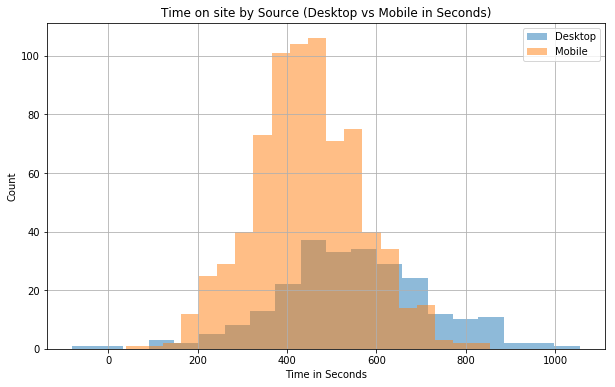

In [20]:
import matplotlib.pyplot as plt

user_data.groupby('mobile').time_on_site.hist(bins = 20, alpha =0.5, figsize=(10,6));
plt.title ('Time on site by Source (Desktop vs Mobile in Seconds)')
plt.ylabel('Count')
plt.xlabel('Time in Seconds')
plt.legend(['Desktop','Mobile'])

In [23]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(time_bins,user_data['purchased'] )

purchased,False,True
time_on_site,,
"(-1.055, 211.033]",19,5
"(211.033, 422.067]",194,151
"(422.067, 633.1]",209,304
"(633.1, 844.133]",38,67
"(844.133, 1055.167]",5,8


In [24]:
time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(time_bins,user_data['purchased'], normalize='index' )

purchased,False,True
time_on_site,,
"(-1.055, 211.033]",0.791667,0.208333
"(211.033, 422.067]",0.562319,0.437681
"(422.067, 633.1]",0.407407,0.592593
"(633.1, 844.133]",0.361905,0.638095
"(844.133, 1055.167]",0.384615,0.615385


In [26]:
pd.crosstab(columns=user_data['purchased'], index=time_bins, normalize='index') #otherway without error

purchased,False,True
time_on_site,,
"(-1.055, 211.033]",0.791667,0.208333
"(211.033, 422.067]",0.562319,0.437681
"(422.067, 633.1]",0.407407,0.592593
"(633.1, 844.133]",0.361905,0.638095
"(844.133, 1055.167]",0.384615,0.615385


In [28]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(time_bins,user_data['purchased'],  normalize='columns')

purchased,False,True
time_on_site,,
"(-1.055, 211.033]",0.040860,0.009346
"(211.033, 422.067]",0.417204,0.282243
"(422.067, 633.1]",0.449462,0.568224
"(633.1, 844.133]",0.081720,0.125234
"(844.133, 1055.167]",0.010753,0.014953


In [29]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.548,0.437333
True,0.452,0.562667


In [39]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

pd.crosstab(time_bins, [user_data['purchased'],user_data['mobile']], normalize='columns') # Multi level crosstab!!!!

purchased               False               True           
mobile                  False     True      False     True 
time_on_site                                               
(-1.055, 211.033]    0.043796  0.039634  0.008850  0.009479
(211.033, 422.067]   0.218978  0.500000  0.132743  0.322275
(422.067, 633.1]     0.525547  0.417683  0.442478  0.601896
(633.1, 844.133]     0.175182  0.042683  0.353982  0.063981
(844.133, 1055.167]  0.036496  0.000000  0.061947  0.002370

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)